In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import os
import shutil
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [4]:
print(len(training_dataset))
print(len(validation_dataset))

1768
759


In [5]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [6]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

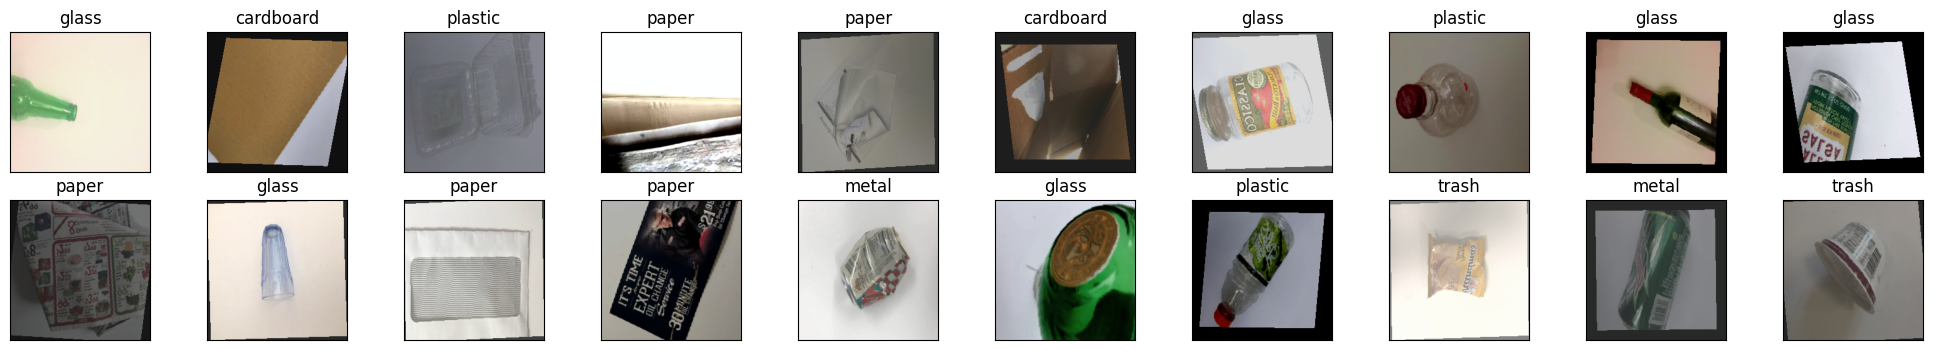

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.__next__()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

## VGG-16

In [8]:
model = models.vgg16(pretrained=True)

D:\Jupyter ipynb\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Jupyter ipynb\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
for param in model.features.parameters():
  param.requires_grad = False

In [11]:
# Print the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 138357544


In [12]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

6


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [14]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

best_val_acc = 0.0
best_epoch = 0
patience = 3  # Adjust this value based on your preference

overall_start_time = time.time()  # Record the start time for the entire training process

for e in range(epochs):
  
    start_time = time.time()  # Record the start time for the epoch

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    # Training loop
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            # Validation loop
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
            
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        end_time = time.time()  # Record the end time for the epoch
        epoch_time = end_time - start_time  # Calculate the time taken for the epoch

        print('epoch:', (e+1))
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        print('time taken for epoch {}: {:.2f} seconds'.format(e+1, epoch_time))

        # Check for early stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_epoch = e + 1  # Epochs are 1-indexed

        if e - best_epoch >= patience:
            print(f'Early stopping at epoch {e+1}. No improvement in validation accuracy.')
            break

overall_end_time = time.time()  # Record the end time for the entire training process
overall_time = overall_end_time - overall_start_time  # Calculate the overall time taken
print('Overall time taken for {} epochs: {:.2f} seconds'.format(epochs, overall_time))
print(f'Best epoch: {best_epoch}, Best validation accuracy: {best_val_acc.item()}')

epoch: 1
training loss: 0.0519, acc 0.6069
validation loss: 0.0304, validation acc 0.7721
time taken for epoch 1: 48.09 seconds
epoch: 2
training loss: 0.0346, acc 0.7415
validation loss: 0.0288, validation acc 0.7892
time taken for epoch 2: 45.21 seconds
epoch: 3
training loss: 0.0282, acc 0.7981
validation loss: 0.0254, validation acc 0.8221
time taken for epoch 3: 45.41 seconds
epoch: 4
training loss: 0.0239, acc 0.8252
validation loss: 0.0259, validation acc 0.8142
time taken for epoch 4: 45.91 seconds
epoch: 5
training loss: 0.0205, acc 0.8512
validation loss: 0.0260, validation acc 0.8090
time taken for epoch 5: 46.09 seconds
Overall time taken for 5 epochs: 230.71 seconds
Best epoch: 3, Best validation accuracy: 0.8221343755722046


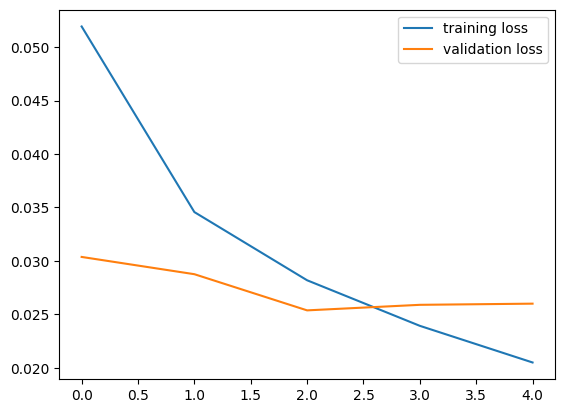

In [15]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

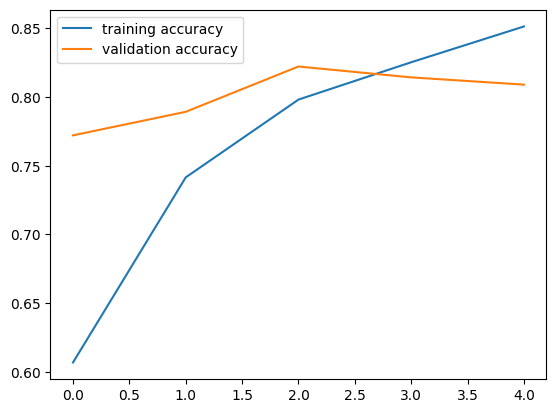

In [16]:
# Convert tensors to NumPy arrays and then to Python lists
running_corrects_history_list = [tensor.item() for tensor in running_corrects_history]
val_running_corrects_history_list = [tensor.item() for tensor in val_running_corrects_history]

# Plotting accuracy curves
plt.plot(running_corrects_history_list, label='training accuracy')
plt.plot(val_running_corrects_history_list, label='validation accuracy')
plt.legend()
plt.show()

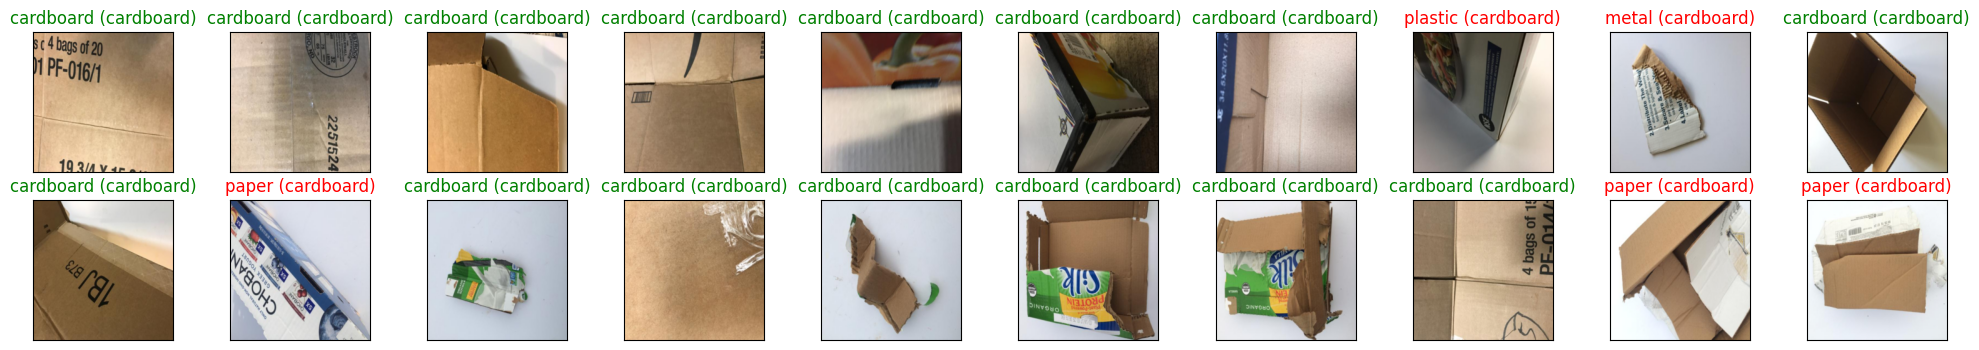

In [17]:
dataiter = iter(validation_loader)
images, labels = dataiter.__next__()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [19]:
# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_preds = []

for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

In [20]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[276   0   0  10   1   0]
 [  1 315  22   1  15   0]
 [  0   8 271   0   7   0]
 [  3   2   5 385   2   6]
 [  0  16   6   5 317   3]
 [  3   5   7   6   8  62]]

Precision for each class:
cardboard: 0.9753
glass: 0.9104
metal: 0.8714
paper: 0.9459
plastic: 0.9057
trash: 0.8732

Recall for each class:
cardboard: 0.9617
glass: 0.8898
metal: 0.9476
paper: 0.9553
plastic: 0.9135
trash: 0.6813


In [21]:
# Calculate overall precision
overall_precision = precision_score(all_labels, all_preds, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.9199


In [22]:
# Calculate overall recall
overall_recall = recall_score(all_labels, all_preds, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.9197
Overall F1 Score: 0.9189


In [23]:
# Initialize empty lists to store true labels and predicted labels
all_labels_t = []
all_preds_t = []

for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels_t.extend(labels.cpu().numpy())
    all_preds_t.extend(preds.cpu().numpy())

In [24]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels_t, all_preds_t)

# Calculate precision and recall for each class
precision = precision_score(all_labels_t, all_preds_t, average=None)
recall = recall_score(all_labels_t, all_preds_t, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[103   0   2   9   2   0]
 [  0 123  14   0  10   0]
 [  0  24  92   1   6   1]
 [  7   3   4 173   3   1]
 [  0  28   9   1  95   2]
 [  0   4   2   5   7  28]]

Precision for each class:
cardboard: 0.9364
glass: 0.6758
metal: 0.7480
paper: 0.9153
plastic: 0.7724
trash: 0.8750

Recall for each class:
cardboard: 0.8879
glass: 0.8367
metal: 0.7419
paper: 0.9058
plastic: 0.7037
trash: 0.6087


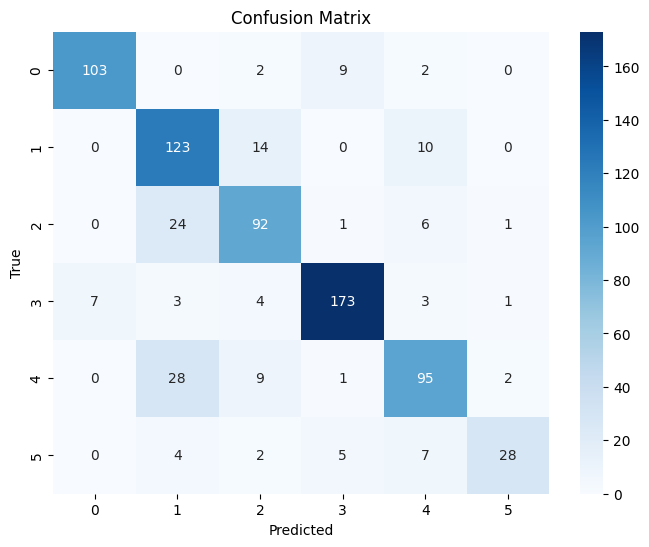

In [25]:
import seaborn as sns

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(all_labels_t),
            yticklabels=np.unique(all_labels_t))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
# Calculate overall precision
overall_precision = precision_score(all_labels_t, all_preds_t, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.8169


In [27]:
# Calculate overall recall
overall_recall = recall_score(all_labels_t, all_preds_t, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels_t, all_preds_t, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.8090
Overall F1 Score: 0.8095


## VGG-19

In [7]:
model = models.vgg19(pretrained=True)

D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:
for param in model.features.parameters():
  param.requires_grad = False

In [10]:
# Print the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 143667240


In [11]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

6


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

In [13]:
epochs = 50
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

best_val_acc = 0.0
best_epoch = 0
patience = 3  # Adjust this value based on your preference

overall_start_time = time.time()  # Record the start time for the entire training process

for e in range(epochs):
  
    start_time = time.time()  # Record the start time for the epoch

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    # Training loop
    model.train()
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            # Validation loop
            model.eval()
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
            
        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        
        end_time = time.time()  # Record the end time for the epoch
        epoch_time = end_time - start_time  # Calculate the time taken for the epoch

        print('epoch:', (e+1))
        print('training loss: {:.4f}, acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
        print('time taken for epoch {}: {:.2f} seconds'.format(e+1, epoch_time))

        # Check for early stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_epoch = e + 1  # Epochs are 1-indexed

        if e - best_epoch >= patience:
            print(f'Early stopping at epoch {e+1}. No improvement in validation accuracy.')
            break

overall_end_time = time.time()  # Record the end time for the entire training process
overall_time = overall_end_time - overall_start_time  # Calculate the overall time taken
print('Overall time taken for {} epochs: {:.2f} seconds'.format(epochs, overall_time))
print(f'Best epoch: {best_epoch}, Best validation accuracy: {best_val_acc.item()}')

epoch: 1
training loss: 0.0503, acc 0.3512
validation loss: 0.0417, validation acc 0.5968
time taken for epoch 1: 70.55 seconds
epoch: 2
training loss: 0.0387, acc 0.5549
validation loss: 0.0327, validation acc 0.6693
time taken for epoch 2: 69.83 seconds
epoch: 3
training loss: 0.0323, acc 0.6488
validation loss: 0.0275, validation acc 0.7009
time taken for epoch 3: 69.90 seconds
epoch: 4
training loss: 0.0284, acc 0.6810
validation loss: 0.0240, validation acc 0.7339
time taken for epoch 4: 69.93 seconds
epoch: 5
training loss: 0.0246, acc 0.7285
validation loss: 0.0222, validation acc 0.7510
time taken for epoch 5: 70.02 seconds
epoch: 6
training loss: 0.0239, acc 0.7302
validation loss: 0.0204, validation acc 0.7681
time taken for epoch 6: 70.09 seconds
epoch: 7
training loss: 0.0214, acc 0.7607
validation loss: 0.0196, validation acc 0.7708
time taken for epoch 7: 70.24 seconds
epoch: 8
training loss: 0.0203, acc 0.7721
validation loss: 0.0187, validation acc 0.7787
time taken for

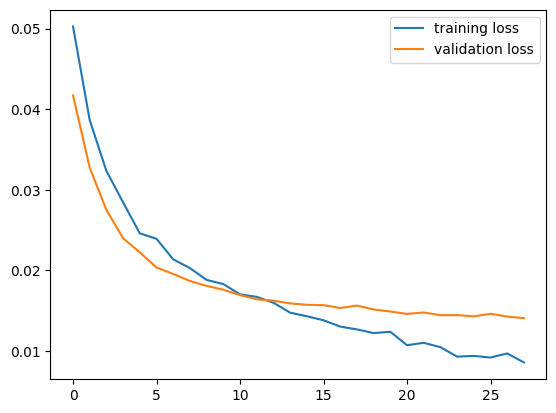

In [14]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

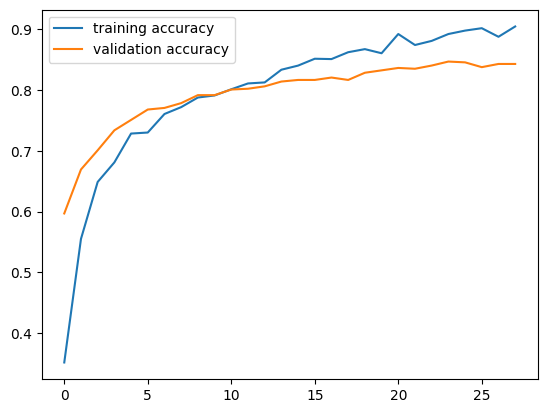

In [15]:
# Convert tensors to NumPy arrays and then to Python lists
running_corrects_history_list = [tensor.item() for tensor in running_corrects_history]
val_running_corrects_history_list = [tensor.item() for tensor in val_running_corrects_history]

# Plotting accuracy curves
plt.plot(running_corrects_history_list, label='training accuracy')
plt.plot(val_running_corrects_history_list, label='validation accuracy')
plt.legend()
plt.show()

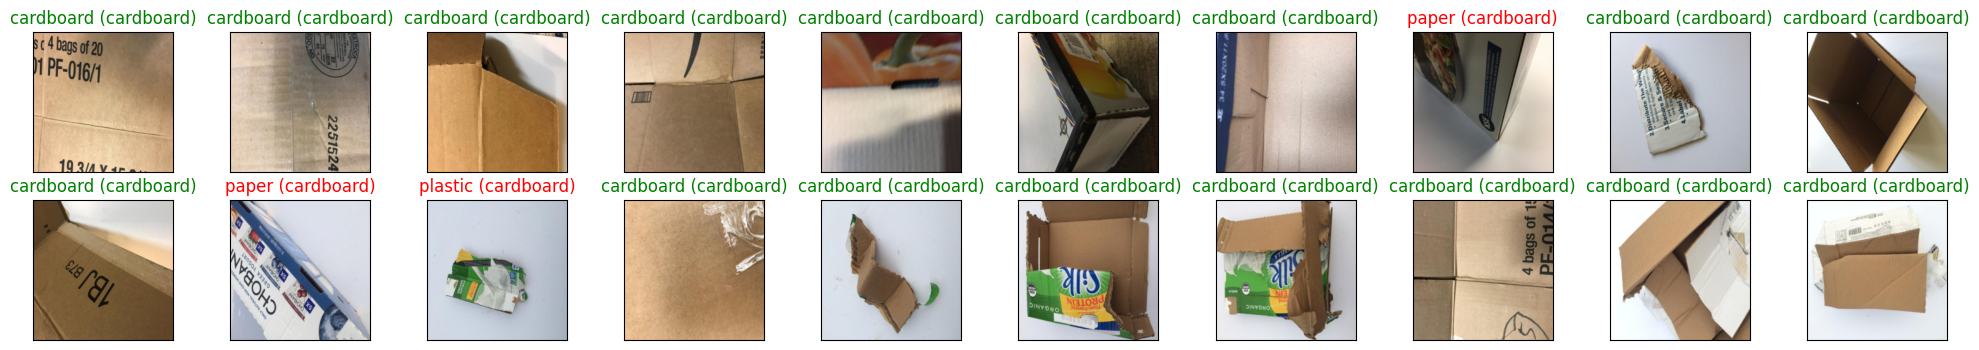

In [16]:
dataiter = iter(validation_loader)
images, labels = dataiter.__next__()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [18]:
# Initialize empty lists to store true labels and predicted labels
all_labels = []
all_preds = []

for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())

In [19]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Calculate precision and recall for each class
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[281   0   0   4   0   2]
 [  0 335   7   2   8   2]
 [  0   7 272   1   5   1]
 [  7   0   4 386   0   6]
 [  3  10   2   4 326   2]
 [  2   1   2   5   2  79]]

Precision for each class:
cardboard: 0.9590
glass: 0.9490
metal: 0.9477
paper: 0.9602
plastic: 0.9560
trash: 0.8587

Recall for each class:
cardboard: 0.9791
glass: 0.9463
metal: 0.9510
paper: 0.9578
plastic: 0.9395
trash: 0.8681


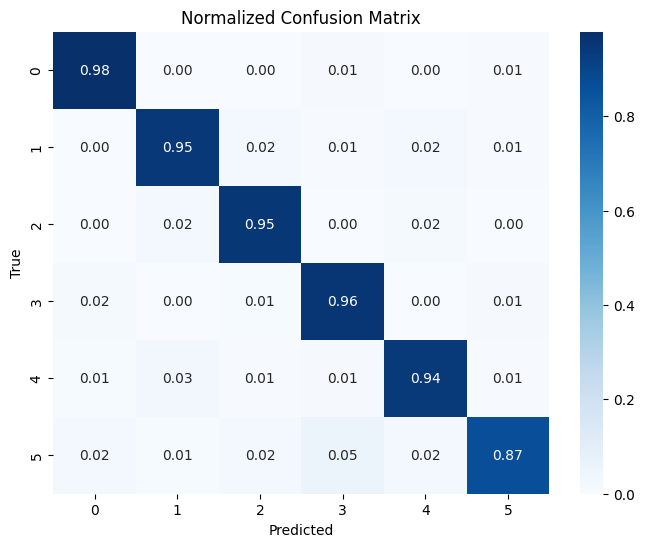

In [20]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [21]:
# Calculate overall precision
overall_precision = precision_score(all_labels, all_preds, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.9497


In [22]:
# Calculate overall recall
overall_recall = recall_score(all_labels, all_preds, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels, all_preds, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.9497
Overall F1 Score: 0.9497


In [23]:
# Initialize empty lists to store true labels and predicted labels
all_labels_t = []
all_preds_t = []

for inputs, labels in validation_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    all_labels_t.extend(labels.cpu().numpy())
    all_preds_t.extend(preds.cpu().numpy())

In [24]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels_t, all_preds_t)

# Calculate precision and recall for each class
precision = precision_score(all_labels_t, all_preds_t, average=None)
recall = recall_score(all_labels_t, all_preds_t, average=None)

# Print confusion matrix, precision, and recall for each class
print('Confusion Matrix:')
print(conf_matrix)

# Print precision for each class
print('\nPrecision for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], precision[i]))

# Print recall for each class
print('\nRecall for each class:')
for i in range(len(classes)):
    print('{}: {:.4f}'.format(classes[i], recall[i]))

Confusion Matrix:
[[106   0   0   8   2   0]
 [  0 116  14   0  16   1]
 [  0   7 108   4   4   1]
 [  6   0   2 172   7   4]
 [  0  14   6   1 110   4]
 [  0   5   5   2   6  28]]

Precision for each class:
cardboard: 0.9464
glass: 0.8169
metal: 0.8000
paper: 0.9198
plastic: 0.7586
trash: 0.7368

Recall for each class:
cardboard: 0.9138
glass: 0.7891
metal: 0.8710
paper: 0.9005
plastic: 0.8148
trash: 0.6087


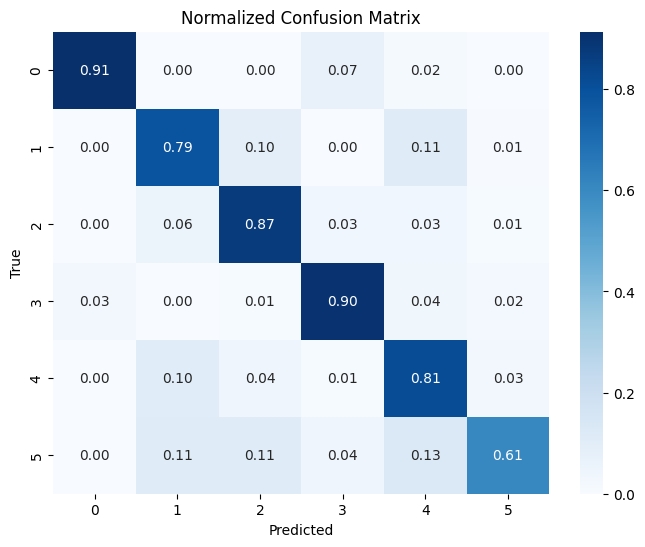

In [25]:
import seaborn as sns

# Normalize the confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=np.unique(all_labels_t),
            yticklabels=np.unique(all_labels_t))
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [26]:
# Calculate overall precision
overall_precision = precision_score(all_labels_t, all_preds_t, average='weighted')

# Print overall precision
print('\nOverall Precision: {:.4f}'.format(overall_precision))


Overall Precision: 0.8446


In [27]:
# Calculate overall recall
overall_recall = recall_score(all_labels_t, all_preds_t, average='weighted')

# Calculate overall F1 score
overall_f1 = f1_score(all_labels_t, all_preds_t, average='weighted')

# Print overall recall and F1 score
print('\nOverall Recall: {:.4f}'.format(overall_recall))
print('Overall F1 Score: {:.4f}'.format(overall_f1))


Overall Recall: 0.8432
Overall F1 Score: 0.8430
